# Example of factorizing quantum linear systems with time-delayed feedback

In [62]:
import numpy
from numpy import linalg as la

import sympy
from sympy import init_printing
init_printing()

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [63]:
## We use some functions from https://github.com/tabakg/potapov_interpolation

import sys
P_dir = '/Users/gil/Google Drive/repos/potapov/potapov_interpolation/Potapov_Code/'
sys.path.append(P_dir)
import Roots
from Potapov import get_Potapov_vecs
from functions import der
from functions import limit

In [64]:
import utils
reload(utils)

from utils import(
    double_up,
    J,
    flat,
    make_ABCD,
    make_T,
    scale_vector_doubled_up,
    real_scaling,
    make_Sigma,
    check_J_unitary,
    check_doubled_up_func,
    check_doubled_up_mat,
    purge,
    complex_prod_deg,
    factorize_complex_poles,
    factorize_real_poles,
    factorize_deg_real_pole,
    make_Jv,
    make_Sigma,
    get_squeezed_spectrum
)

## Symbols we will use for the construction.

In [3]:
r, kappa, eps, delta, z = sympy.symbols('r kappa epsilon delta z')

## Generate a specific system from Example VI.1 : Enhanced squeezing via coherent feedback from page 31 of https://arxiv.org/pdf/1611.00375.pdf with added time delay.

## Example 1, using eq. 122 in the example, i.e. the squeezer and the beamsplitter are in series, but *the feedback loop has not been closed*. There are two inputs and two outputs.

In [65]:
Omega_p = sympy.Matrix([1j*eps])
Omega_m = sympy.Matrix([delta])
Omega = double_up(Omega_p,Omega_m, second_row_minus=True)

Phi_p = sympy.zeros(2,1)
Phi_m = sympy.zeros(2,1)
Phi_m[0,0] = -sympy.sqrt(1-r**2)*sympy.sqrt(kappa)
Phi_m[1,0] = r*sympy.sqrt(kappa)
Phi = double_up(Phi_p,Phi_m)

S = sympy.Matrix([[-sympy.sqrt(1-r**2),r],[r,sympy.sqrt(1-r**2)]])

In [66]:
A,B,C,D = make_ABCD(S,Phi,Omega)

In [67]:
T_z = make_T(A,B,C,D,z)

## Testing numerical values

$T(z)$ Should satisfy the J-unitary property when $z$ is purely imaginary

In [68]:
T_z_num = T_z.subs({kappa:1.0, r:0.97, eps:0.1, delta:0.}).expand()
T = sympy.lambdify( (z), T_z_num)
M = A.shape[0]/2
N = D.shape[0]/2
JA = numpy.matrix(numpy.diag([1 for i in range(M)]+[-1 for i in range(M)]))
JD = numpy.matrix(numpy.diag([1 for i in range(N)]+[-1 for i in range(N)]))
all([check_J_unitary(T, i*1j) for i in range(-10,10)])

True

## Root finding

In [69]:
T_det = lambda z: 1./la.det(T(z))
# T_det_der = lambda z: der(T_det,z)
# poles = Roots.get_roots_rect(T_det, T_det_der, 0.,0.,5.,5.,N=10)

poles = []

for i in numpy.linspace(-2,2,10):
    for j in numpy.linspace(-2,2,10):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_det)
        if abs(p) < 100:
            poles.append(p)

In [70]:
significant_poles = Roots.purge(poles, eps = 1e-1)
significant_poles

[(-0.6000175413337322-1.3897163958927726e-06j),
 (-0.39999985032203128+2.0630057146058824e-07j)]

In [71]:
significant_poles = [p.real for p in significant_poles]

## Check if J-contractive

In [72]:
J_test = np.matrix(np.diag([1,1,-1,-1]))

In [73]:
z_test = 3

In [74]:
la.eig(T(z_test) * J_test * T(z_test).H - J_test)

(array([ -2.22044605e-16,  -4.90196078e-01,   4.90196078e-01,
          2.68986382e-16]),
 matrix([[  9.70000000e-01,   2.43104916e-01,  -4.29083852e-19,
           -2.30226354e-19],
         [  2.43104916e-01,  -9.70000000e-01,  -1.07538550e-19,
            3.98335390e-19],
         [  0.00000000e+00,   0.00000000e+00,  -2.43104916e-01,
            9.70000000e-01],
         [ -4.56035553e-19,   1.81960322e-18,   9.70000000e-01,
            2.43104916e-01]]))

## Factorize function

In [75]:
J2 = numpy.matrix(numpy.diag([1,1,-1,-1]))

In [76]:
vecs = get_Potapov_vecs(T,[s for s in significant_poles])
u1, u2 = vecs

w1 = scale_vector_doubled_up(u1)
w2 = scale_vector_doubled_up(u2)
v1, v2 = real_scaling(w1, w2)
if (v1.H*J2*v2).imag < 0:
    v1, v2 = v2, v1
    significant_poles.reverse()
U = numpy.matrix([[1,1],[-1j,1j]])
V = numpy.hstack([v1,v2])*U
V_flat = JA*V.H*JD

In [78]:
## Check V is doubled-up
check_doubled_up_mat(V)

True

## We should have $I = V^\flat*V$ and $P_v = V*V^\flat$ should be a projector.

In [79]:
Pv = V*V_flat

In [80]:
## Check V_flat * V is close the I.
print la.norm(V_flat*V - numpy.matrix(numpy.eye(2)))

5.63761325104e-07


In [81]:
## Check Pv is a projector.
print la.norm(Pv - Pv**2)

5.63761325148e-07


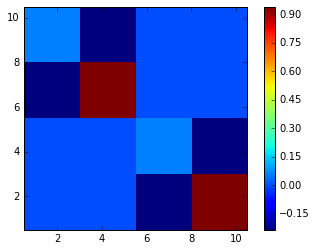

In [82]:
## Check what the projection looks like
plt.imshow((V*V_flat).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

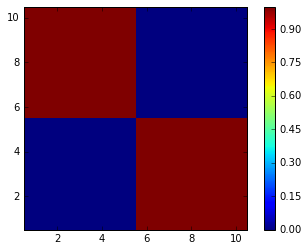

In [83]:
plt.imshow((V_flat*V).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()

In [84]:
## Construct factors for real roots.

F1 = lambda z: (numpy.matrix([[(z + significant_poles[1])/(z-significant_poles[0]), 0],
                            [0, (z + significant_poles[0])/(z-significant_poles[1])]])
                )

T_factorized_1 = lambda z: numpy.matrix(numpy.eye(D.shape[0])) - V*V_flat + V*la.inv(U)*F1(z)*(U)*V_flat

B_constant = T(1e12)*la.inv(T_factorized_1(1e12))

fact1 = lambda z: (B_constant*T_factorized_1(z)).T

### Ensure the generated factor is J-unitary and doubled-up

In [85]:
T_factorized_1(10j)*J2*T_factorized_1(10j)-J2

matrix([[ -1.17591960e-03 +1.17307683e-02j,
           4.69197425e-03 -4.68063138e-02j,
          -1.33133680e-10 -1.18634289e-11j,
           5.31209617e-10 +4.73356368e-11j],
        [  4.69197403e-03 -4.68063138e-02j,
          -1.87211961e-02 +1.86759379e-01j,
          -3.24313095e-11 -9.16504074e-12j,
           1.29402445e-10 +3.65689426e-11j],
        [  1.32692759e-10 +1.47836322e-11j,
           3.41906051e-11 -2.48670609e-12j,
           1.17591909e-03 -1.17307648e-02j,
          -4.69197226e-03 +4.68063009e-02j],
        [ -5.29450322e-10 -5.89873837e-11j,
          -1.36422117e-10 +9.92206957e-12j,
          -4.69197226e-03 +4.68063009e-02j,
           1.87211891e-02 -1.86759333e-01j]])

In [86]:
J2 = numpy.matrix(numpy.diag([1,1,-1,-1]))

In [87]:
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Check the factor equals the original transfer function

In [88]:
def plot_T_and_fact(T, fact1, z):
    plt.title("Original transfer function, real part.")
    plt.imshow((T(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, real part.")
    plt.imshow((fact1(z)).real, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("Original transfer function, imaginary part.")
    plt.imshow((T(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

    plt.title("New factor, imaginary part.")
    plt.imshow((fact1(z)).imag, interpolation='nearest', extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

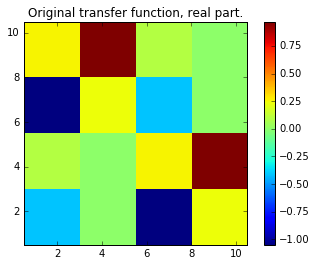

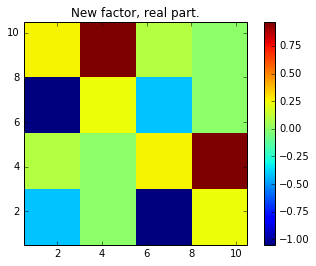

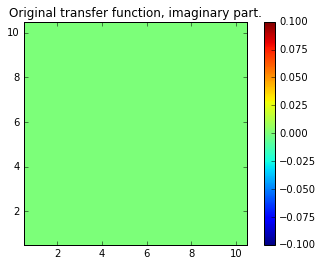

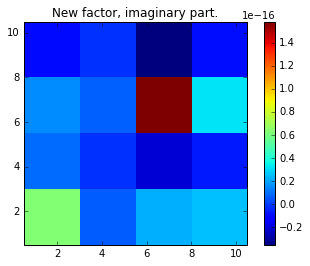

In [89]:
plot_T_and_fact(T, fact1, 0)

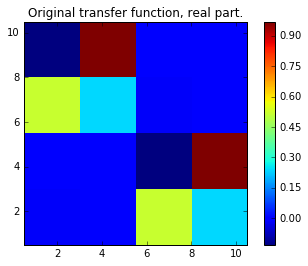

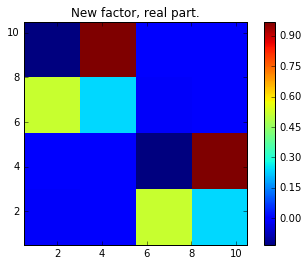

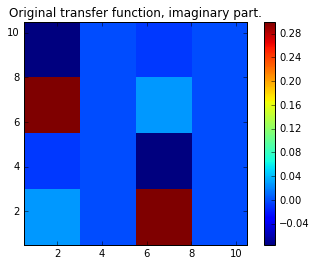

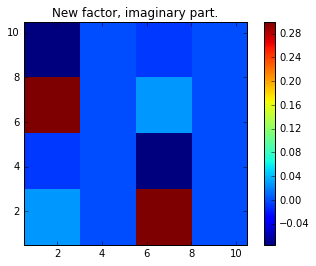

In [90]:
plot_T_and_fact(T, fact1, 1j+1.)

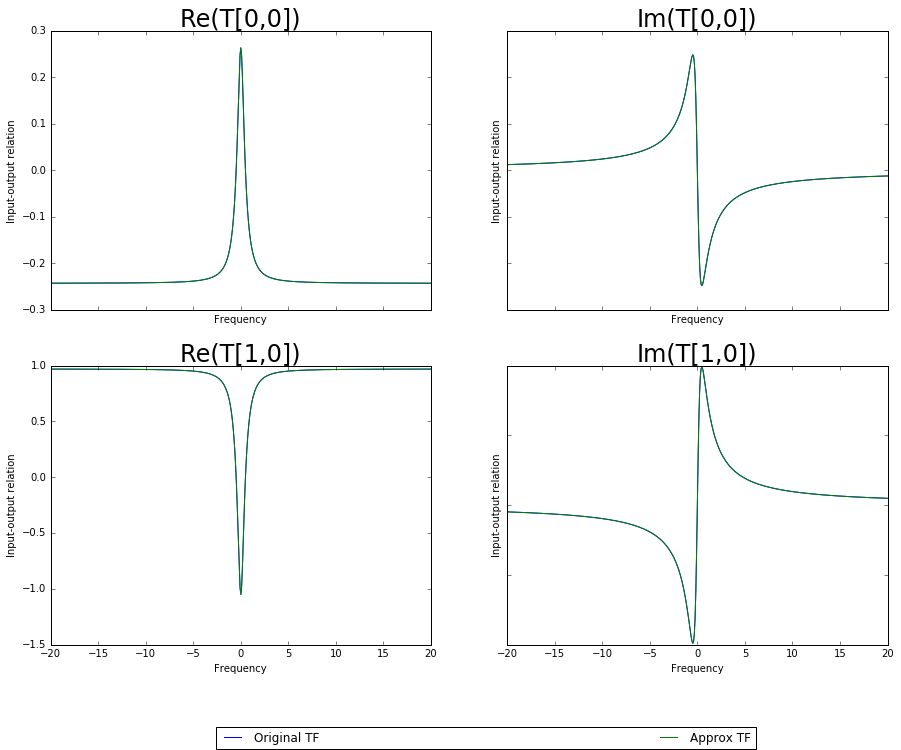

In [91]:
xr = numpy.linspace(-20,20,501)
xr_im = xr*1j
yr = numpy.array(map(T, xr_im))
zr = numpy.array(map(fact1, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(15,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )


f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

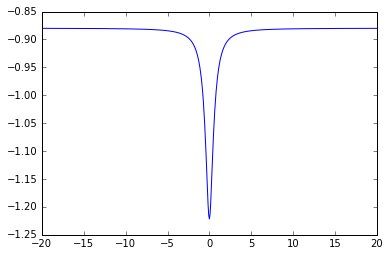

In [93]:
# Analysis of squeezing spectrum.

PP = get_squeezed_spectrum(zr).real
plt.plot(xr.real, -PP)

## Example 2. Next we close the feedback loop with a time delay and

### Feedback operation

In [94]:
T_old = sympy.lambdify(z, T_z_num)

In [95]:
P = numpy.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

In [96]:
def perm(N, tuples):
    P_tot = np.matrix(numpy.eye(N))
    for t in tuples:
        P = np.matrix(numpy.zeros((N,N)))
        for i in range(N):
            if i == t[0]:
                P[t[1],t[0]] = 1
            elif i == t[1]:
                P[t[0],t[1]] = 1
            else:
                P[i,i] = 1
        P_tot = P * P_tot ## New operators come from the left...
    return P_tot

In [97]:
# P_in = perm(8, [(1,2), (0,1), (5,6), (4,5)])
P_out = perm(4, [(0,1), (2,3)])

In [98]:
P_out

matrix([[ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.]])

In [99]:
P

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [100]:
T_o = P*P_out*T_z_num * P_out*P.T

In [101]:
T1 = sympy.lambdify(z, T_o[0:2,0:2])

In [102]:
T2 = sympy.lambdify(z, T_o[0:2,2:4])

In [103]:
T3 = sympy.lambdify(z, T_o[2:4,0:2])

In [104]:
T4 = sympy.lambdify(z, T_o[2:4, 2:4])

### Check some properties that should be true

In [105]:
Jv = numpy.matrix([[1,0],[0,-1]])

In [106]:
print la.norm(T1(0)*Jv*T1(0).H +T2(0)*Jv*T2(0).H - Jv) < 1e-5

True


In [107]:
print la.norm(T1(0)*Jv*T3(0).H +T2(0)*Jv*T4(0).H) < 1e-5

True


In [108]:
print la.norm(T3(0)*Jv*T3(0).H +T4(0)*Jv*T4(0).H - Jv) < 1e-5

True


In [109]:
I = numpy.matrix(numpy.eye(2))

### Feedback without time delay

In [110]:
T_tilde_0 = lambda z: T1(z) + T2(z)*la.inv(I - T4(z))* T3(z)

In [111]:
print all([[check_J_unitary(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde_0,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Feedback with time delay

In [112]:
t = 5.0
E = lambda z: numpy.matrix(numpy.diag(numpy.exp(2*[-t*z])))
T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

In [113]:
print all([[check_J_unitary(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_tilde,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


### Plot of input-output function

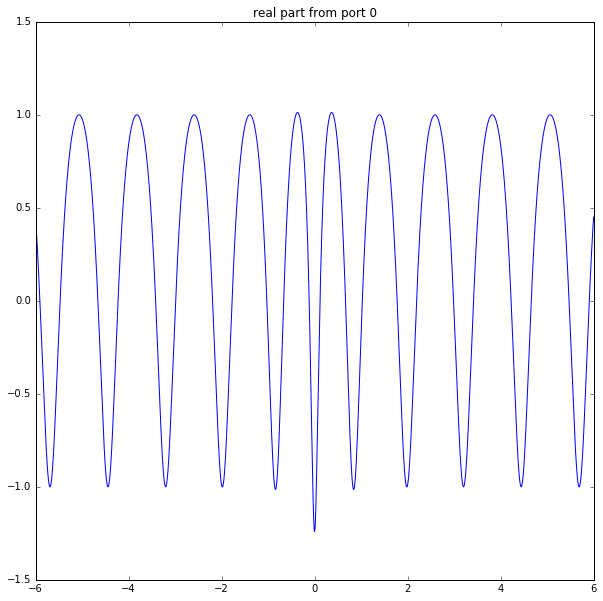

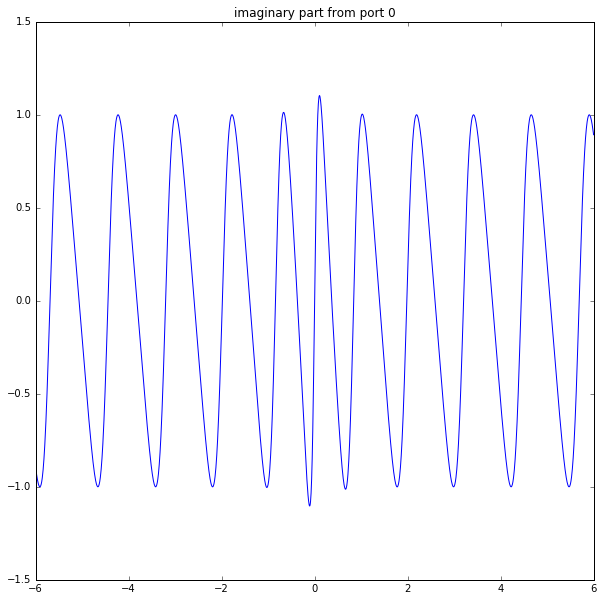

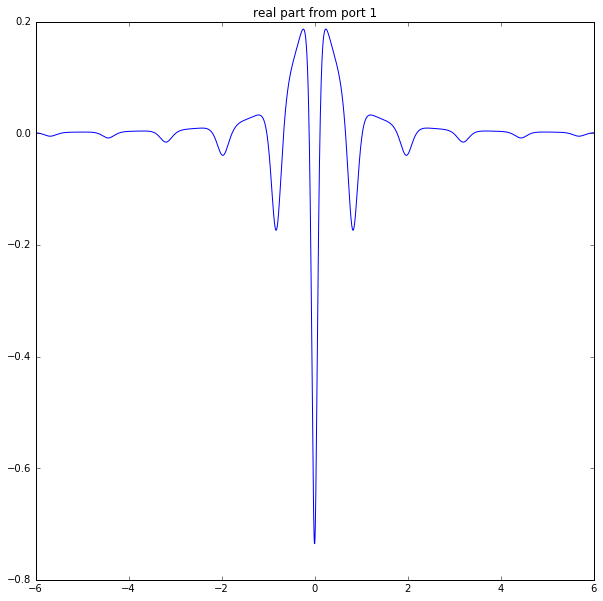

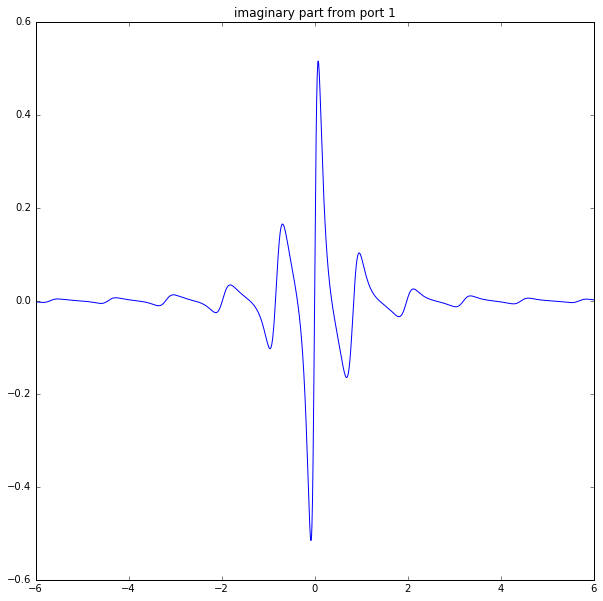

In [114]:
xr = numpy.linspace(-6,6,2000)
yr = numpy.array(map(T_tilde, xr*1j))

for i in range(yr.shape[1]):
    plt.figure(figsize=(10,10))
    plt.title("real part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].real)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.title("imaginary part from port %s" % str(i))
    plt.plot(xr, yr[:,i,0].imag)
    plt.show()

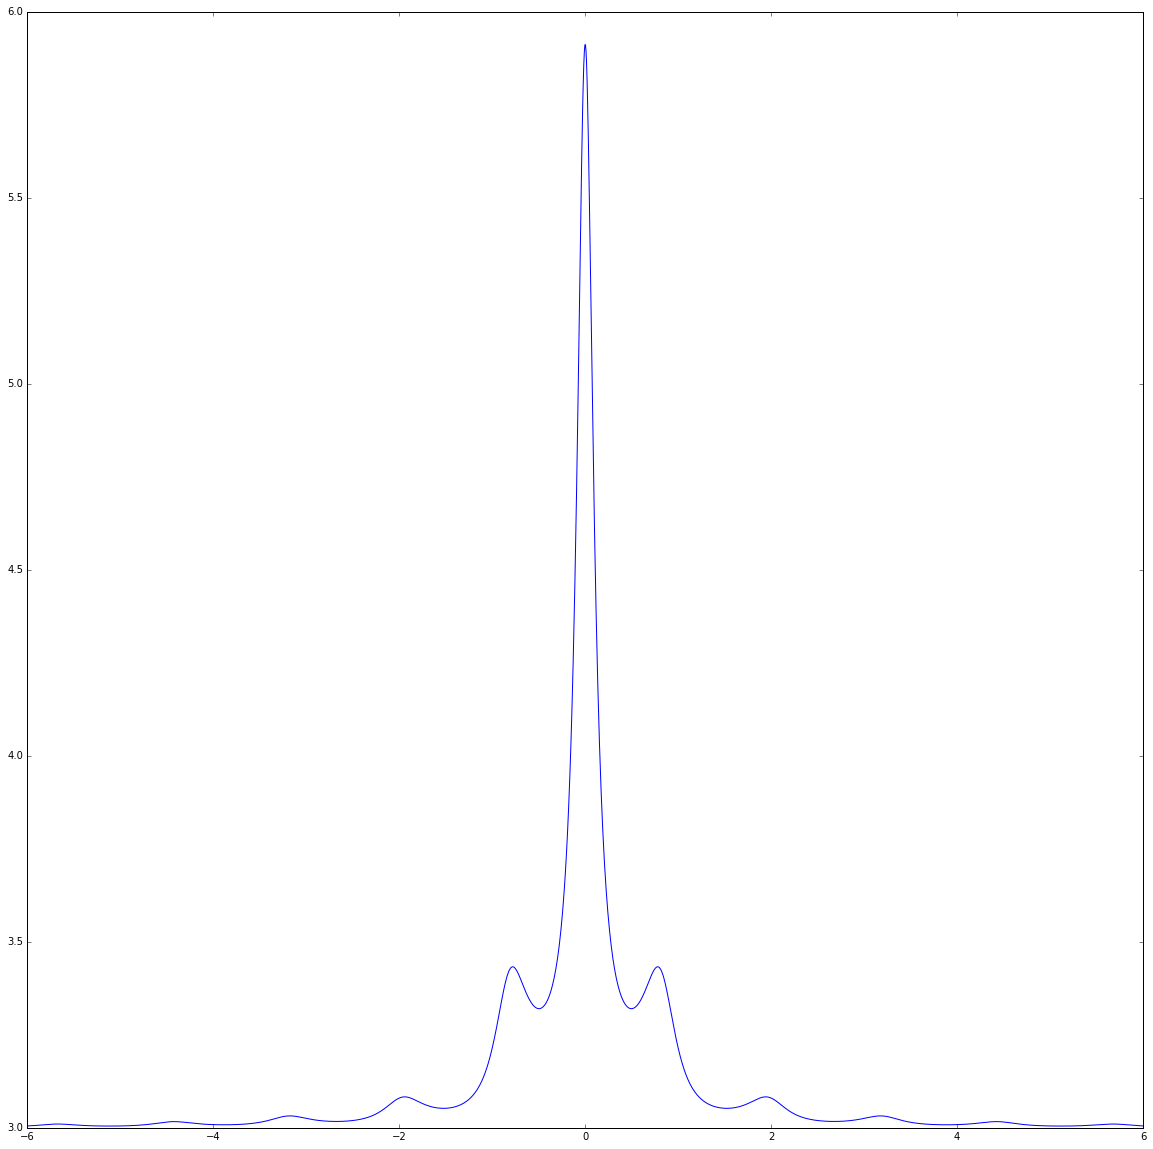

In [115]:
# Analysis of squeezing spectrum.

# r_squeeze = 0.5*numpy.log((numpy.abs(yr[:,0,0])+numpy.abs(yr[:,1,0]))
#                           /(numpy.abs(yr[:,0,0])-numpy.abs(yr[:,1,0])))

# plt.plot(xr, r_squeeze)
# plt.show()


# r_squeeze_trunc = 0.5*numpy.log((numpy.abs(zr[:,0,0])+numpy.abs(zr[:,1,0]))
#                           /(numpy.abs(zr[:,0,0])-numpy.abs(zr[:,1,0])))


# plt.plot(xr, r_squeeze_trunc)
# plt.show()

which_vals = yr

plt.figure(figsize = (20,20))
N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

theta = 0 #numpy.pi / 4

A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
B_ = N_+numpy.flip(N_, axis=0)

# Squeezing power spectrum
PP = 1 + A_ + B_
plt.plot(xr, PP)

## Compute difference between squeezing spectra for different time delays used

In [117]:
def get_squeezing(t=10.):
    E = lambda z: numpy.matrix(numpy.diag(numpy.exp(2*[-t*z])))
    T_tilde = lambda z: T1(z) + T2(z) * la.inv( E(-z) - T4(z) ) * T3(z)

    xr = numpy.linspace(-6,6,2000)
    yr = numpy.array(map(T_tilde, xr*1j))

    which_vals = yr

    N_ = which_vals[:,0,0]*which_vals[:,0,0].conj()
    M_ = which_vals[:,0,0]*numpy.flip(which_vals[:,0,1], axis=0)

    theta = 0.

    A_ = numpy.exp(2j*theta)* M_ + numpy.exp(-2j*theta)* numpy.flip(M_, axis=0).conj()
    B_ = N_+numpy.flip(N_, axis=0)

    # Squeezing power spectrum
    PP = 1 + A_ + B_
    return (xr, PP)

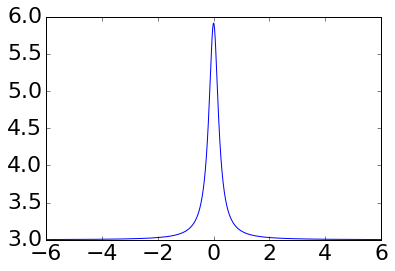

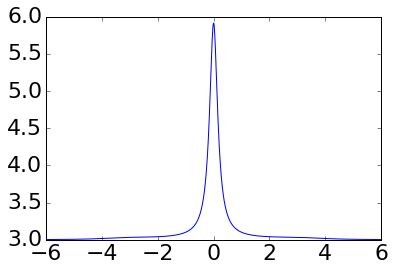

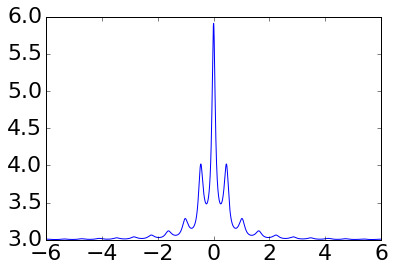

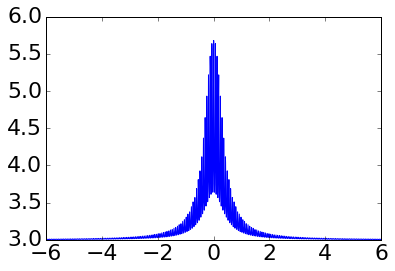

In [177]:
for t in [1e-5, 1., 10., 100.]:
    (xr1, PP1) = get_squeezing(t)
    plt.plot(xr1, PP1)
    plt.show()

## Next, find the roots for $\tilde T(z)$.

In [123]:
T_tilde_det = lambda z: 1./la.det(T_tilde(z))

### The method above didn't work well, so we use grid + Muller search.

In [124]:
poles_tilde = []

for i in numpy.linspace(-1,0,11):
    for j in numpy.linspace(-10,10,80):
        x1,x2,x3 = i+j*1j-0.101, i+j*1j+0.101, i+j*1j+0.001
        p = Roots.Muller(x1,x2,x3,T_tilde_det)
        poles_tilde.append(p)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/gil/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [125]:
for i in numpy.linspace(-10,0,1000):
    x1,x2,x3 = i, i-0.001, i+0.001
    p = Roots.Muller(x1,x2,x3,T_tilde_det)
    poles_tilde.append(p)

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [126]:
poles_tilde_purged = purge(Roots.inside_boundary(poles_tilde, 0., 0., 10., 10.), 2e-2)

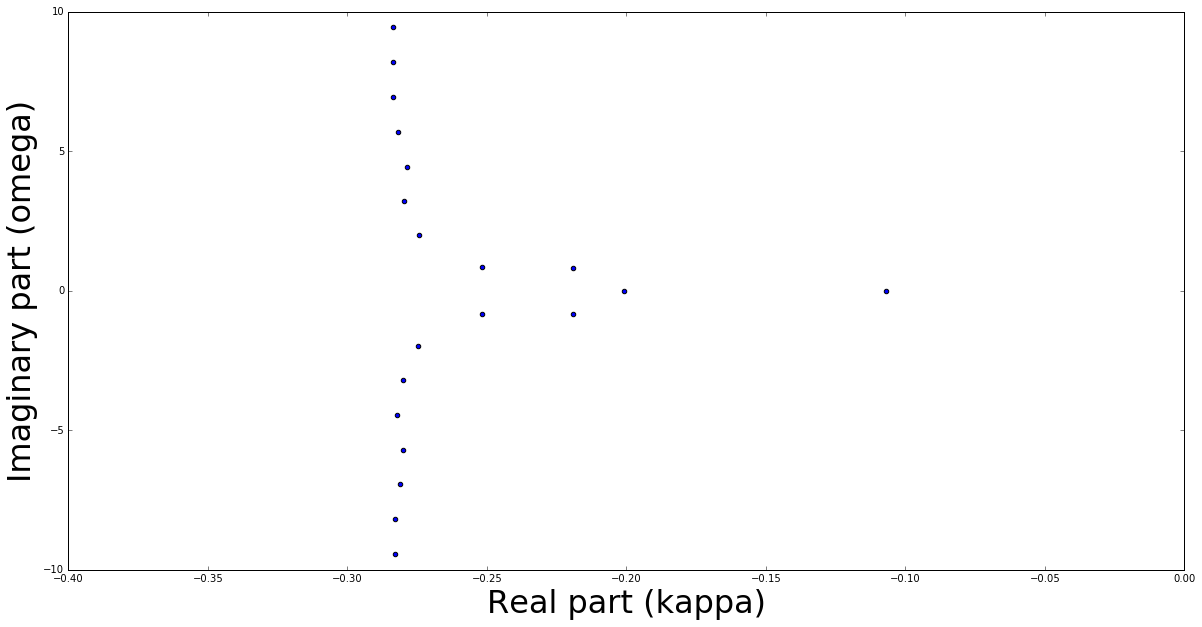

In [128]:
plt.figure(figsize=(20,10))
plt.scatter(np.array(poles_tilde_purged).real,np.array(poles_tilde_purged).imag, )
# plt.title("Poles", fontsize=18)
plt.xlim(-0.4,0)
plt.ylim(-10,10)
plt.xlabel("Real part (kappa)", fontsize=32)
plt.ylabel("Imaginary part (omega)", fontsize=32)

### Organize the poles into different categories

In [129]:
real_cutoff = 1e-3

In [130]:
complex_poles = [p for p in poles_tilde_purged if abs(p.imag) >= real_cutoff]

In [131]:
real_poles = [p.real for p in poles_tilde_purged if abs(p.imag) < real_cutoff]
real_poles = [p for p in real_poles if abs(p) < 4.]

In [132]:
pos_complex_poles = sorted([p for p in complex_poles if p.imag > real_cutoff], key = lambda z: z.imag)

In [133]:
neg_complex_poles =  [p for p in complex_poles if p.imag < -real_cutoff]

In [134]:
pos_complex_poles

[(-0.21916258399255825+0.82742940345563853j),
 (-0.25156799422582027+0.83909285263602262j),
 (-0.2742817949987098+1.9825452436962823j),
 (-0.27963275626634726+3.2035272361586209j),
 (-0.27870581873391415+4.4418642064378542j),
 (-0.2818549247544111+5.6905574796125498j),
 (-0.28376051633499766+6.9412363390195795j),
 (-0.28357199526576132+8.1928368073842073j),
 (-0.28378204754260916+9.4457195888142085j)]

In [135]:
real_poles

## Factorize real poles

In [136]:
deg_cutoff = 1e-3
deg_real_poles = []
non_deg_real_poles = []

for pole in real_poles:
    L = limit(lambda z: (z+pole)*T_tilde(z),pole, N=1000, eps=deg_cutoff*deg_cutoff)
    vals, vecs = la.eig(L)
    index = np.argmax(map(abs,vals))
    u = vecs[:,index] ## vector to be used in case of 1-dim eigenspace
    
    ## Make Sigma
    sub_sigma = numpy.diag([1]*(u.shape[0]/2))
    M = u.shape[0]/2
    Sigma = numpy.vstack((
                numpy.hstack((np.zeros((M,M)),sub_sigma)),
                numpy.hstack((sub_sigma,np.zeros((M,M))))
            ))

    print ("The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().")
    print pole, la.norm(u - Sigma*u.conj())

    if la.norm(u - Sigma*u.conj()) > deg_cutoff:
        non_deg_real_poles.append(pole)
    else:
        deg_real_poles.append(pole)        
        

The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().
-0.20095963229 2.22942910636e-11
The eigenspace will have dimension > 1 if a vector cannot be rescaled such u = Sigma*u.conj().
-0.10683767184 2.63560561663e-12


In [137]:
non_deg_real_poles

In [138]:
deg_real_poles

In [139]:
### Assume there are only two degenerate poles. Pair them together

In [140]:
# p1, p2 = non_deg_real_poles
p3, p4 = real_poles

In [141]:
## Factor out the non-degenerate poles.
T_factorized_1 = factorize_real_poles(p3, p4, T_tilde)

In [142]:
### Check J-unitary and doubled-up properties.
print all([[check_J_unitary(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_factorized_1,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [143]:
### Detach the factor T_factorized_1
T_tilde_2 = lambda z: T_tilde(z)*la.inv(T_factorized_1(z))*T_factorized_1(0.)

### Check to see poles are removed

In [144]:
## Values should be large near a pole
T_tilde(p3+1e-5)

matrix([[-21370.52954755,  21376.95817185],
        [ 21376.95817185, -21370.52954755]])

In [145]:
## Values should be O(1).
T_tilde_2(p3+1e-5)

matrix([[-1.78494501 -8.32918361e-14j, -1.04657256 -8.31843902e-14j],
        [-1.04657256 +8.33999720e-14j, -1.78494501 +8.33390791e-14j]])

In [146]:
## Values should be large near a pole
T_tilde(p4+1e-5)

matrix([[-19845.22699949, -19842.59516155],
        [-19842.59516155, -19845.22699949]])

In [147]:
## Values should be O(1).
T_tilde_2(p4+1e-3)

matrix([[-1.50915557 +3.82261136e-16j, -0.89385133 -3.10616472e-16j],
        [-0.89385133 +4.41028473e-16j, -1.50915557 -3.58775623e-16j]])

### Factorize the (degenerate) complex poles

In [149]:
which_poles = [pos_complex_poles[0], 
               pos_complex_poles[1].conj(), 
              ] 

In [150]:
import copy

In [153]:
## Print the unperturbed vectors. They are degenerate when v.H*J*v = 0.
which_vecs = factorize_complex_poles(which_poles, T_tilde_2, verbose=False, eps=1e-4)

In [154]:
T_c = lambda z: complex_prod_deg(z, which_poles, which_vecs, 2, eps=0.)

In [155]:
### Check the resulting function is J-unitary and doubled-up.

In [156]:
print all([[check_J_unitary(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

print all([[check_doubled_up_func(T_c,i+1j*j)
          for i in range(-5,5)] 
             for j in range(-5,5)])

True
True


In [157]:
T_c(0.)

matrix([[ 1.00107031 -5.72998205e-06j,  0.04627917 +1.56598780e-05j],
        [ 0.04627917 -1.56598780e-05j,  1.00107031 +5.72998205e-06j]])

### Generate and plot the factorized functions.

In [158]:
z0 = 0 ## Point at which we specify the new function should equal the original.
T_fact = lambda z: (
      T_tilde(z0) 
  *la.inv(T_factorized_1(z0)) * T_factorized_1(z)
    *la.inv(T_c(z0))*T_c(z)
                   )

In [159]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

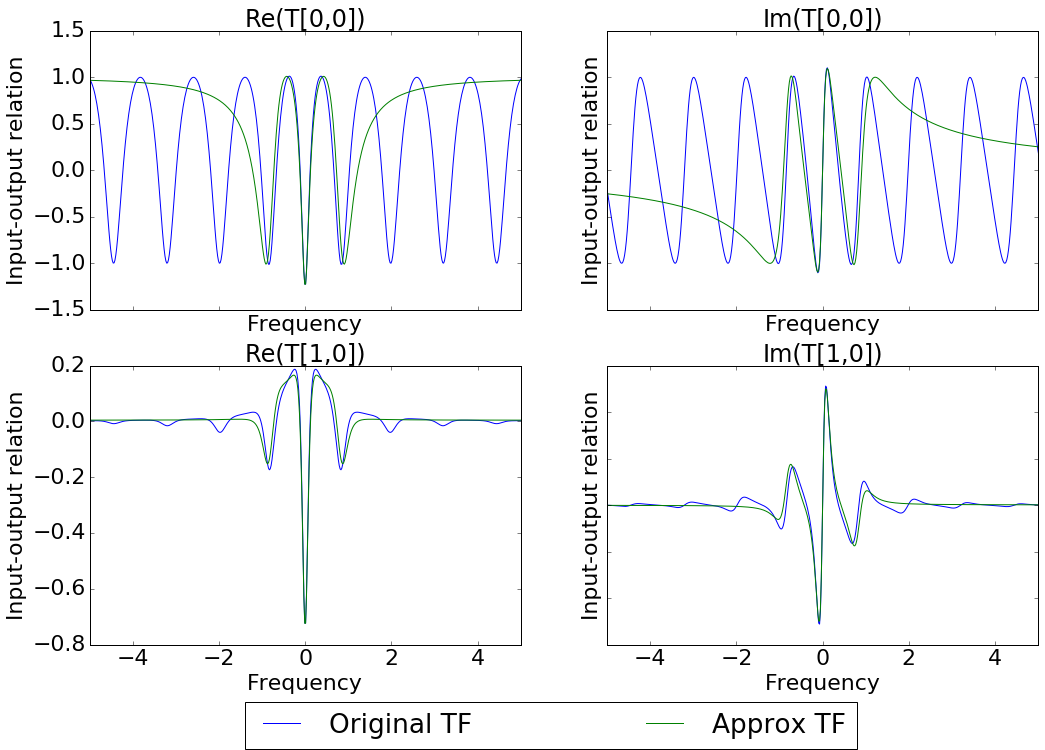

In [160]:

xr = numpy.linspace(-30,30,3000)
xr_im = xr*1j
yr = numpy.array(map(T_tilde, xr_im))
zr = numpy.array(map(T_fact, xr_im))

f, axarr = plt.subplots(2, 2, figsize=(17,11))

l1, = axarr[0, 0].plot(xr, yr[:,0,0].real)
l2, = axarr[0, 0].plot(xr, zr[:,0,0].real)
axarr[0, 0].set_title('Re(T[0,0])',fontsize= 24)

axarr[0, 1].plot(xr, yr[:,0,0].imag)
axarr[0, 1].plot(xr, zr[:,0,0].imag)
axarr[0, 1].set_title('Im(T[0,0])' ,fontsize= 24)

axarr[1, 0].plot(xr, yr[:,1,0].real)
axarr[1, 0].plot(xr, zr[:,1,0].real)
axarr[1, 0].set_title('Re(T[1,0])',fontsize= 24 )

axarr[1, 1].plot(xr, yr[:,1,0].imag)
axarr[1, 1].plot(xr, zr[:,1,0].imag)
axarr[1, 1].set_title('Im(T[1,0])',fontsize= 24 )




f.legend([l1, l2],["Original TF", "Approx TF"],
           bbox_to_anchor=(0.2, 0.001, 0.5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)


for ax in axarr.flat:
    ax.set(xlabel='Frequency', ylabel='Input-output relation', xlim=(-5,5) )
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axarr.flat:
    ax.label_outer()
    

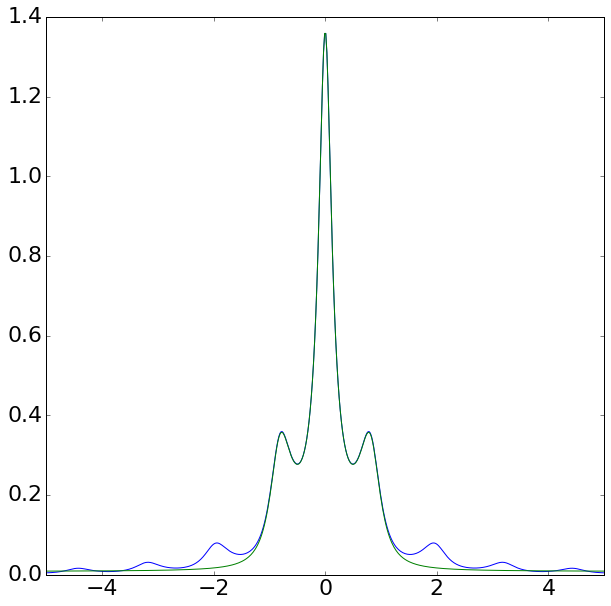

In [161]:


plt.figure(figsize=(10,10))
PP = get_squeezed_spectrum(yr)
y_offset = PP[0]
plt.plot(xr, PP)

PP = get_squeezed_spectrum(zr)
plt.plot(xr, PP)
plt.xlim(-5,5)

 (0, 10000),

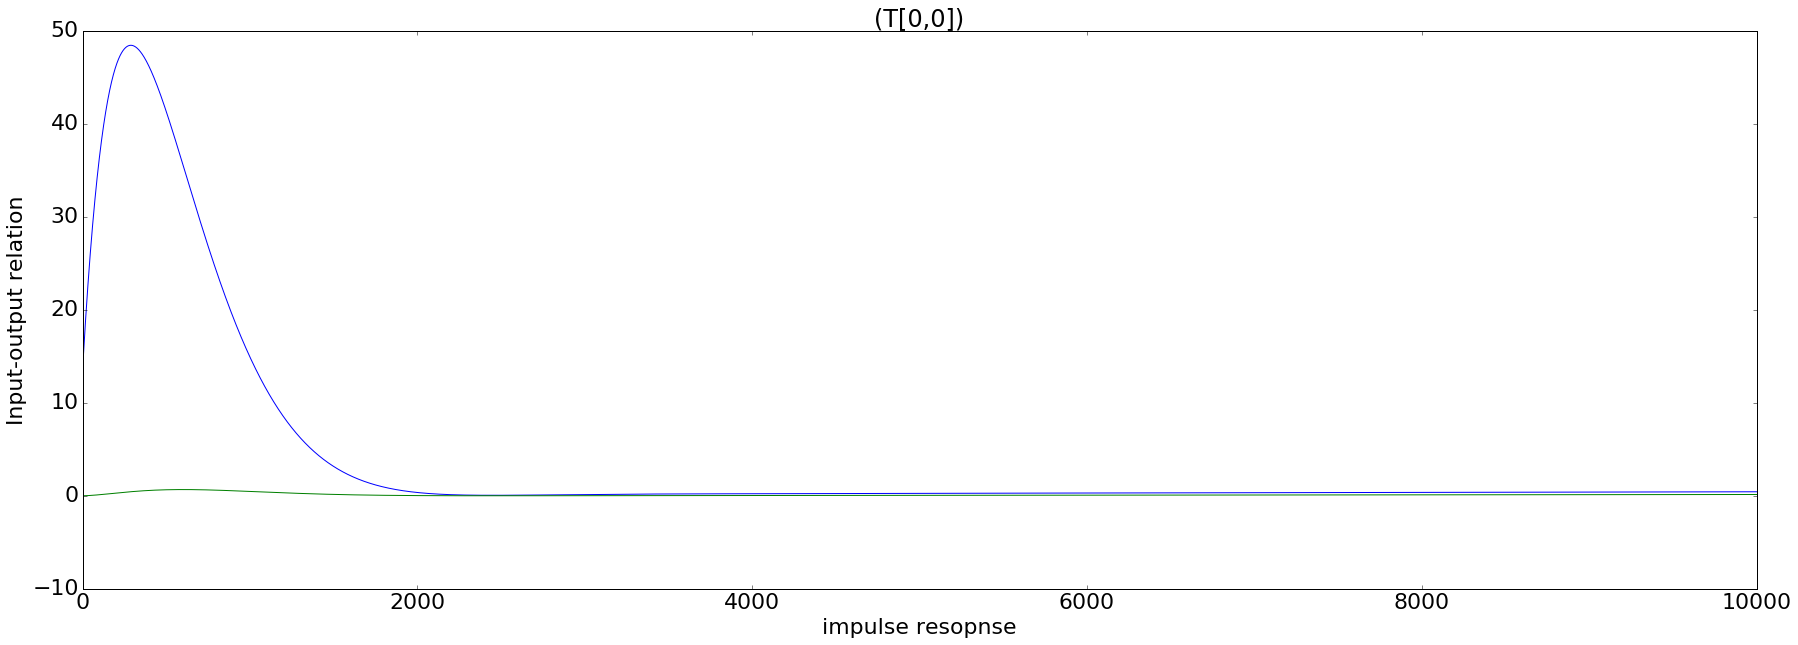

In [188]:
def get_PP(T, xr = numpy.linspace(-20,20,501), theta=np.pi/4):
    zr = np.array([T_tilde(x) for x  in xr*1j])
    PP = get_squeezed_spectrum(zr)
    return xr, PP


from scipy.fftpack import fft

xr = numpy.linspace(0,1000,100001)
_, PP = get_PP(T, xr)

# imp_yr = numpy.fft.fft(yr, axis=0)
imp_PP = fft(PP, axis=0)

f, ax = plt.subplots(figsize=(30,10))

l1, = ax.plot(imp_PP.real)
l2, = ax.plot(imp_PP.imag)
ax.set_title('(T[0,0])',fontsize= 24)


ax.set(xlabel='impulse resopnse', ylabel='Input-output relation', xlim=(0,10000))
